<a href="https://colab.research.google.com/github/stoic-vishnu/Engine-for-Startup/blob/main/Task3_Mahavishnu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PART - 1: Load & Preprocess the Dataset**

In [11]:
# === Task 3: Startup Recommendation Engine ===
# Author: Mahavishnu | ScaleDux AI Intern Challenge

import pandas as pd

# Mount Google Drive (if using Colab with your own file later)
# from google.colab import drive
# drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv("Cleaned_User_Matching_Dataset.csv")  # change path if needed

# Split into Founders and Providers
founders_df = df[df["user_type"] == "Founder"].copy().reset_index(drop=True)
providers_df = df[df["user_type"] != "Founder"].copy().reset_index(drop=True)

# Clean text columns for matching
def clean_text_columns(df, columns):
    for col in columns:
        df[col] = df[col].astype(str).str.strip().str.lower()
    return df

founders_cols = ["startup_industry", "project_need", "tech_requirement", "project_deadline"]
providers_cols = ["industry_preference", "preferred_project_type", "core_skill", "availability"]

founders_df = clean_text_columns(founders_df, founders_cols)
providers_df = clean_text_columns(providers_df, providers_cols)

print("✅ Data loaded and cleaned successfully! Proceed to Matching !!")


✅ Data loaded and cleaned successfully! Proceed to Matching !!


# **Part - 2 : Matching Score Function**

In [12]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

def compute_match_score(founder, provider, explain=False):
    score = 0
    parts = []
    weights = {
        "industry": 0.3,
        "tech_skill": 0.3,
        "project_type": 0.2,
        "timeline": 0.2
    }

    # Industry
    if founder["startup_industry"] == provider["industry_preference"]:
        score += weights["industry"] * 100
        parts.append("industry:matched")
    else:
        parts.append("industry:not_matched")

    # Tech Skill
    if founder["tech_requirement"] == provider["core_skill"]:
        score += weights["tech_skill"] * 100
        parts.append("skill:matched")
    else:
        vec = CountVectorizer().fit_transform([
            founder["tech_requirement"], provider["core_skill"]
        ])
        sim = cosine_similarity(vec)[0, 1]
        score += weights["tech_skill"] * 100 * sim
        parts.append(f"skill:similar_{round(sim*100):.0f}")

    # Project Type
    if founder["project_need"] == provider["preferred_project_type"]:
        score += weights["project_type"] * 100
        parts.append("project:matched")
    else:
        vec = CountVectorizer().fit_transform([
            founder["project_need"], provider["preferred_project_type"]
        ])
        sim = cosine_similarity(vec)[0, 1]
        score += weights["project_type"] * 100 * sim
        parts.append(f"project:similar_{round(sim*100):.0f}")

    # Timeline
    deadline_map = {"immediate": 3, "2 weeks": 2, "1 month": 1, "2 months": 0}
    founder_deadline = deadline_map.get(founder["project_deadline"], 0)
    provider_availability = deadline_map.get(provider["availability"], 0)

    if provider_availability >= founder_deadline:
        score += weights["timeline"] * 100
        parts.append("timeline:matched")
    else:
        parts.append("timeline:not_matched")

    explanation = ", ".join(parts)
    return (round(score, 2), explanation) if explain else round(score, 2)

print("🎯 All matching scores calculated successfully. Proceed to Final Result!")


🎯 All matching scores calculated successfully. Proceed to Final Result!


# **Part - 3: Final Result List**

In [13]:
from IPython.display import display

# Create final result list
recommendations = []
top_founders = set()

for i, founder in founders_df.iterrows():
    founder_id = founder["user_id"]
    matches = []

    for j, provider in providers_df.iterrows():
        provider_id = provider["user_id"]
        score = compute_match_score(founder, provider)
        matches.append((provider_id, score))

    top_matches = sorted(matches, key=lambda x: x[1], reverse=True)[:3]

    if top_matches[0][1] == 100:
        top_founders.add(founder_id)

    recommendations.append({
        "Founder ID": founder_id,
        "Match 1": top_matches[0][0], "Score 1": top_matches[0][1],
        "Match 2": top_matches[1][0], "Score 2": top_matches[1][1],
        "Match 3": top_matches[2][0], "Score 3": top_matches[2][1]
    })

match_df = pd.DataFrame(recommendations)

# Display Founder Table
print("✅ Matching done for all founders! Results are ready 📊")
# Display all founders with top score 100
top_100_df = match_df[match_df["Score 1"] == 100.0]
display(top_100_df)



provider_match_results = []
top_providers = set()

for i, provider in providers_df.iterrows():
    matches = []

    for j, founder in founders_df.iterrows():
        score = compute_match_score(founder, provider)
        matches.append((founder["user_id"], score))

    top_matches = sorted(matches, key=lambda x: x[1], reverse=True)[:3]

    if top_matches[0][1] == 100:
        top_providers.add(provider["user_id"])

    provider_match_results.append([
        provider["user_id"],
        top_matches[0][0], top_matches[0][1],
        top_matches[1][0], top_matches[1][1],
        top_matches[2][0], top_matches[2][1]
    ])

provider_match_df = pd.DataFrame(provider_match_results, columns=[
    "Service Provider",
    "Match 1", "Score 1",
    "Match 2", "Score 2",
    "Match 3", "Score 3"
])

print("✅ Matching done for all service provider! Results are ready 📊")
# Filter service providers whose top match score is 100.0
top_100_providers = provider_match_df[provider_match_df["Score 1"] == 100.0]
display(top_100_providers)


✅ Matching done for all founders! Results are ready 📊


,Founder ID,Match 1,Score 1,Match 2,Score 2,Match 3,Score 3
1,F002,S016,100.0,S006,70.0,S040,70.0
15,F016,S028,100.0,S006,70.0,S042,70.0
21,F022,S011,100.0,S001,50.0,S008,50.0
23,F024,S043,100.0,S004,70.0,S012,60.0
43,F044,S018,100.0,S037,100.0,S041,80.0


✅ Matching done for all service provider! Results are ready 📊


,Service Provider,Match 1,Score 1,Match 2,Score 2,Match 3,Score 3
10,S011,F022,100.0,F003,80.0,F008,70.0
15,S016,F002,100.0,F027,80.0,F039,70.0
17,S018,F044,100.0,F012,60.0,F034,60.0
27,S028,F016,100.0,F005,80.0,F042,70.0
36,S037,F044,100.0,F012,80.0,F034,60.0
42,S043,F024,100.0,F020,80.0,F046,80.0


# **Part - 4 : Visualize the data of all Founder matching with service provider**

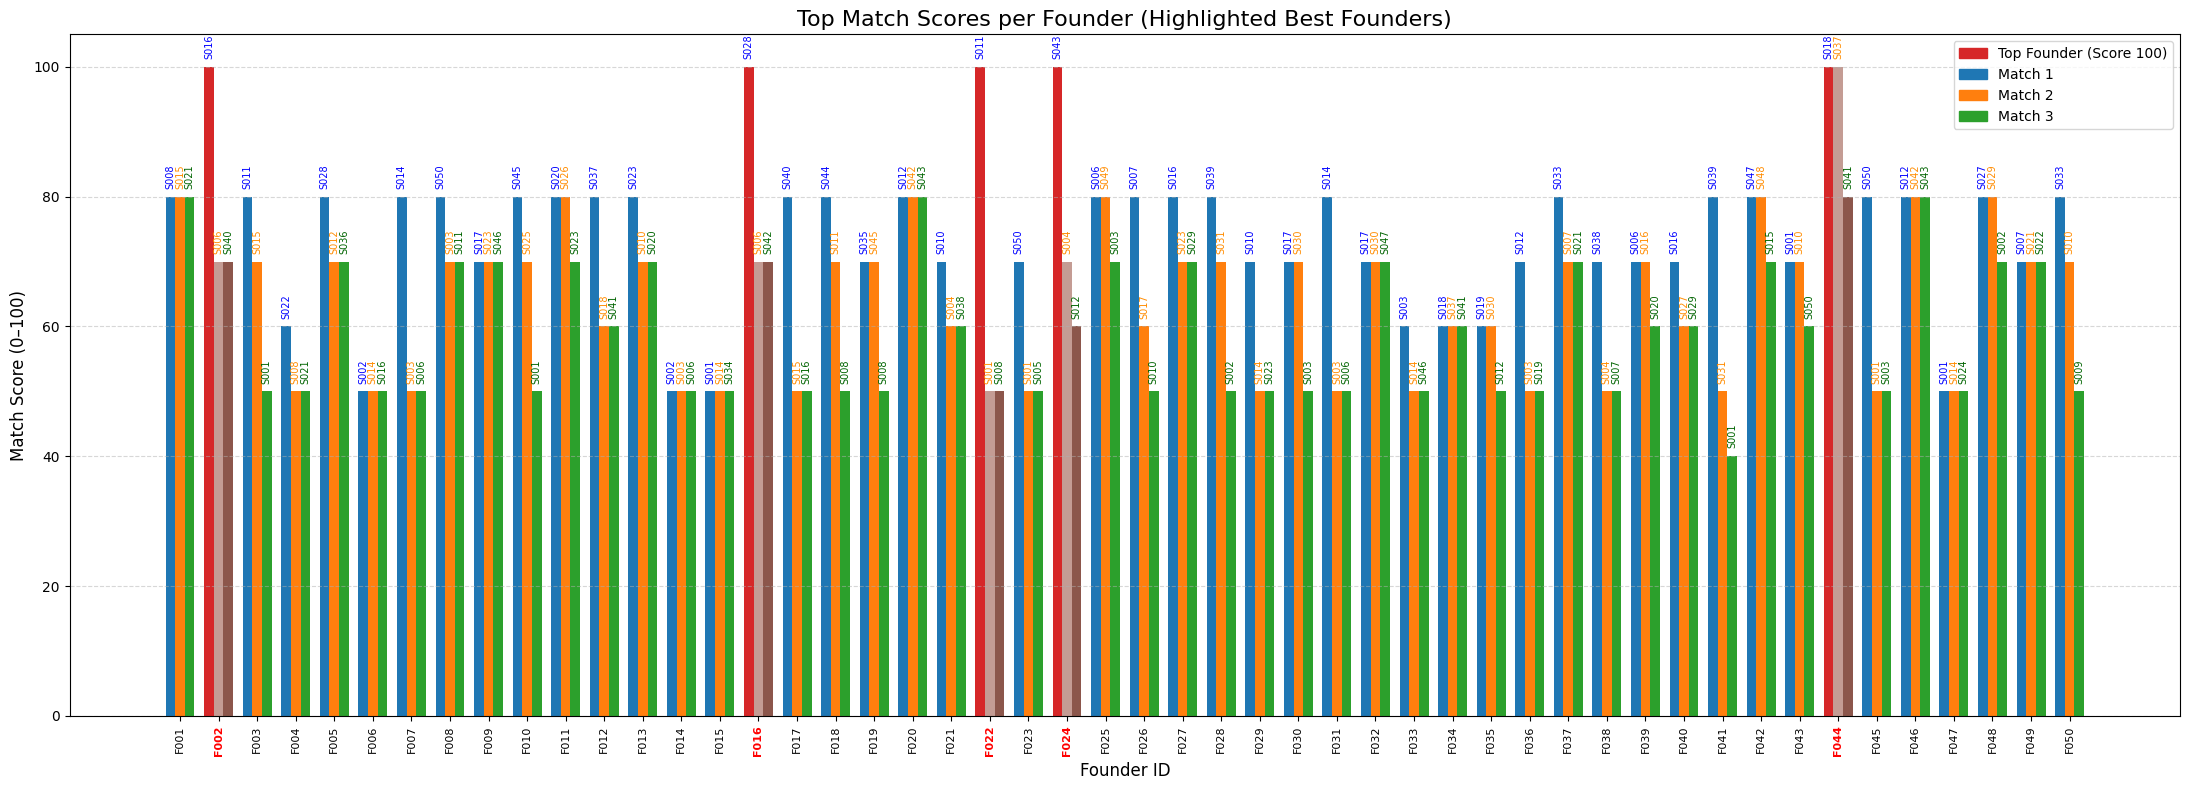

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(22, 8))
x = np.arange(len(match_df["Founder ID"]))
width = 0.25

# 1. Identify top founders by perfect score
highlighted = match_df[match_df["Score 1"] == 100]["Founder ID"].tolist()

# 2. Assign colors
def get_bar_color(founder_id, rank):
    if founder_id in highlighted:
        return "#d62728" if rank == 1 else "#c49c94" if rank == 2 else "#8c564b"
    return "#1f77b4" if rank == 1 else "#ff7f0e" if rank == 2 else "#2ca02c"

# 3. Plot bars with condition-based coloring
for i in range(len(match_df)):
    fid = match_df["Founder ID"][i]

    s1, s2, s3 = match_df["Score 1"][i], match_df["Score 2"][i], match_df["Score 3"][i]

    plt.bar(x[i] - width, s1, width, color=get_bar_color(fid, 1))
    plt.bar(x[i],         s2, width, color=get_bar_color(fid, 2))
    plt.bar(x[i] + width, s3, width, color=get_bar_color(fid, 3))

    # Annotate with Provider IDs
    plt.text(x[i] - width, s1 + 1.5, match_df["Match 1"][i], ha='center', fontsize=7, rotation=90, color="blue")
    plt.text(x[i],         s2 + 1.5, match_df["Match 2"][i], ha='center', fontsize=7, rotation=90, color="darkorange")
    plt.text(x[i] + width, s3 + 1.5, match_df["Match 3"][i], ha='center', fontsize=7, rotation=90, color="darkgreen")

# Create founder labels with color
tick_labels = []
for fid in match_df["Founder ID"]:
    if fid in highlighted:
        tick_labels.append(fid)
    else:
        tick_labels.append(fid)

# Set the ticks
plt.xticks(x, tick_labels, rotation=90, fontsize=8)

# After setting xticks, color them manually
ax = plt.gca()  # get current axis
for label in ax.get_xticklabels():
    if label.get_text() in highlighted:
        label.set_color('red')
        label.set_fontweight('bold')

plt.title("Top Match Scores per Founder (Highlighted Best Founders)", fontsize=16)
plt.xlabel("Founder ID", fontsize=12)
plt.ylabel("Match Score (0–100)", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend(handles=[
    plt.Rectangle((0,0),1,1,color="#d62728", label="Top Founder (Score 100)"),
    plt.Rectangle((0,0),1,1,color="#1f77b4", label="Match 1"),
    plt.Rectangle((0,0),1,1,color="#ff7f0e", label="Match 2"),
    plt.Rectangle((0,0),1,1,color="#2ca02c", label="Match 3")
])
plt.tight_layout()
plt.show()

# **Part - 5: Extra Feature - 360° Match Analysis**

In [15]:
# 🔍 Generate Full Explanation Table: All founders vs providers

explain_records = []

for i, founder in founders_df.iterrows():
    founder_id = founder["user_id"]
    for j, provider in providers_df.iterrows():
        provider_id = provider["user_id"]
        score, reason = compute_match_score(founder, provider, explain=True)
        explain_records.append({
            "Founder ID": founder_id,
            "Provider ID": provider_id,
            "Score": score,
            "Reason": reason
        })

explain_df = pd.DataFrame(explain_records)
explain_df.sort_values(by=["Founder ID", "Score"], ascending=[True, False], inplace=True)
explain_df.reset_index(drop=True, inplace=True)
explain_df.to_csv("founder_provider_explanation.csv", index=False)
print("✅ Done! Full match explanations saved as 'founder_provider_explanation.csv'.")
explain_df.head()


✅ Done! Full match explanations saved as 'founder_provider_explanation.csv'.


,Founder ID,Provider ID,Score,Reason
0,F001,S008,80.0,"industry:matched, skill:matched, project:simil..."
1,F001,S015,80.0,"industry:matched, skill:matched, project:simil..."
2,F001,S021,80.0,"industry:matched, skill:matched, project:simil..."
3,F001,S034,70.0,"industry:not_matched, skill:matched, project:m..."
4,F001,S009,60.0,"industry:matched, skill:matched, project:simil..."
